In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd
from mxnet import autograd
from mxnet import gluon
#from _future_ import print_function

### Set the Context

In [4]:
#Specify Contexts for data and model
#    - This is a good habit to get into
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### Generate Synthetic Data

In [5]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2*X[:,0] - 3.4*X[:,1]+4.2

X = nd.random_normal(shape= (num_examples,num_inputs)
                     ,ctx = data_ctx
                    )

noise = 0.1 * nd.random_normal(shape = (num_examples,)
                               ,ctx = data_ctx
                              )
y = real_fn(X) + noise

In [6]:
print(X[0])
print(y[0])


[ 1.16307867  0.48380461]
<NDArray 2 @cpu(0)>

[ 5.06096601]
<NDArray 1 @cpu(0)>


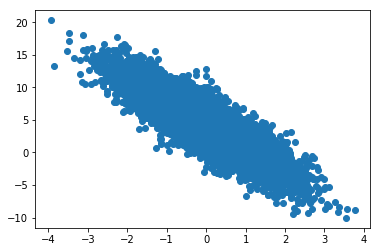

In [9]:
plt.scatter(X[:,1].asnumpy(),y.asnumpy())
plt.show()

### Data Iterators

In [11]:
#Given an ArrayDataset, we can create a DataLoader which 
#will grab random batches of data from an ArrayDataset.

#batch_size: Number of subsamples to grab at a time
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y)
                                  , batch_size = batch_size
                                  , shuffle = True)

In [14]:
#With train_data initialized, batches can be fetched by
#    iterating over it just as if it were a Python list

#Example
for i, (data, label) in enumerate(train_data):
    print(data,label)
    break

(
[[ 0.0863832  -0.26023754]
 [ 0.14997083  0.10876259]
 [-1.10485029  0.17385373]
 [ 2.93443918  1.18337071]]
<NDArray 4x2 @cpu(0)>, 
[ 5.25547457  4.30580282  1.47077656  6.06537104]
<NDArray 4 @cpu(0)>)


In [15]:
counter = 0
for i, (data,label) in enumerate(train_data):
    pass
print i+1

2500


### Model Parameters

In [23]:
#Need to allocate some memory for model parameters
#And initialize them with random values

#These can be thought of as the weight and bias
#matrices of a simple feedforward network
w = nd.random_normal(shape = (num_inputs, num_outputs)
                    , ctx = model_ctx
                    )

b = nd.random.normal(shape=num_outputs
                     , ctx = model_ctx
                    )

params = [w,b]

In [24]:
#Allocate memory for gradients using _attach_grad()
for param in params:
    param.attach_grad()

### Neural Networks

In [30]:
#Define neural net function
def net(X):
    return mx.nd.dot(X,w)+b

### Loss Function

In [26]:
def square_loss(yhat, y):
    return nd.mean((yhat - y)**2)

### Optimizer - Stochastic Gradient Descent

In [27]:
def SGD(params,lr):
    for param in params:
        param[:]  = param - lr*param.grad

### Execute Training Loop

The next step is to wire all the components of the NN together
and write a training loop. This will require defining **epochs**, the number of passes to make over the dataset.

For each pass we'll run through train_data, grabbing batches of
examples and their corresponding labels.

For each batch, the following steps will be executed:
1. Generage predictions(yhat) and the loss(loss) by executing a forward pass through the network
2. Calculate gradients by making a backwards pass through the network(loss.backward())
3. Update the model parameters by invoking the SGD optimizer

In [31]:
epochs = 10
learning_rate = 0.0001
num_batches = num_examples/batch_size

for e in range(epochs):
    cumulative_loss = 0
    
    #inner loop
    for i, (data,label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1,1))
        
        with autograd.record():
            output = net(data)
            loss = square_loss(output,label)
        loss.backward()
        SGD(params,learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss/num_batches)

14.1224445512
5.07730158355
1.82964252004
0.663448756803
0.244715176175
0.0943159530815
0.0403001423395
0.0209091308344
0.0139377229787
0.0114332736522


### Visualizing Training Progress
---

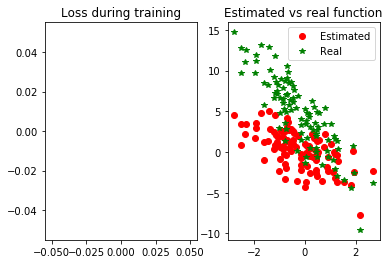

Epoch 0, batch 2499. Mean loss: 13.5906956447


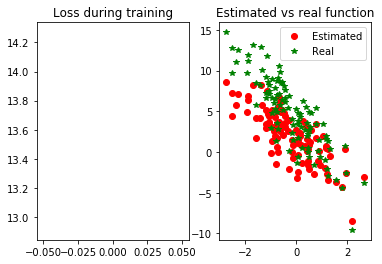

Epoch 1, batch 2499. Mean loss: 4.89290071409


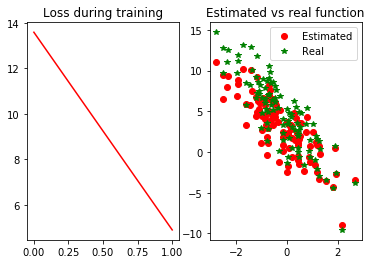

Epoch 2, batch 2499. Mean loss: 1.76601726435


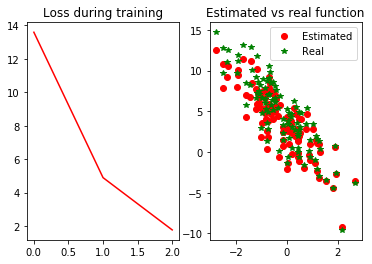

Epoch 3, batch 2499. Mean loss: 0.641633250239


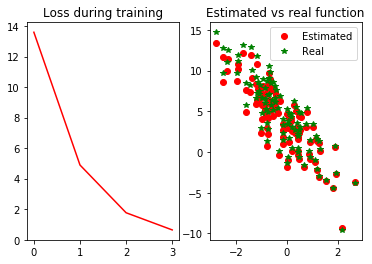

Epoch 4, batch 2499. Mean loss: 0.237309843387


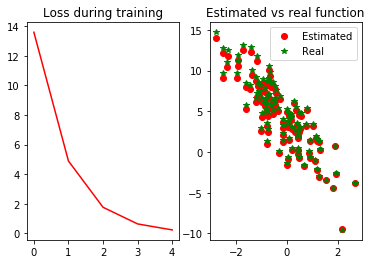

Epoch 5, batch 2499. Mean loss: 0.0918591498952


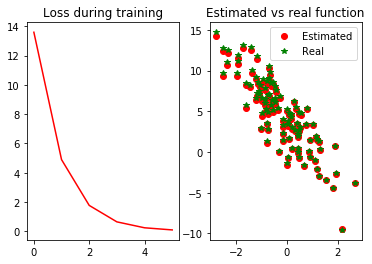

Epoch 6, batch 2499. Mean loss: 0.0394851849999


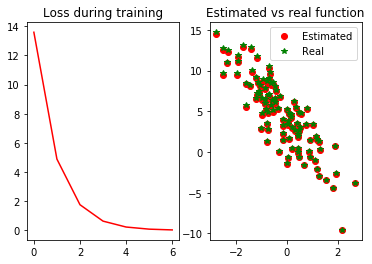

Epoch 7, batch 2499. Mean loss: 0.0206557272598


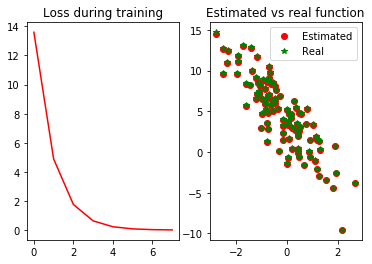

Epoch 8, batch 2499. Mean loss: 0.0138719911771


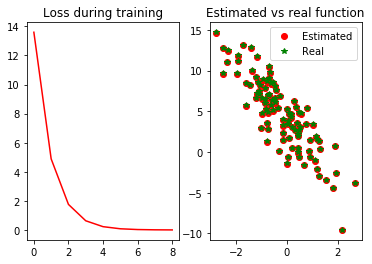

Epoch 9, batch 2499. Mean loss: 0.011416775945


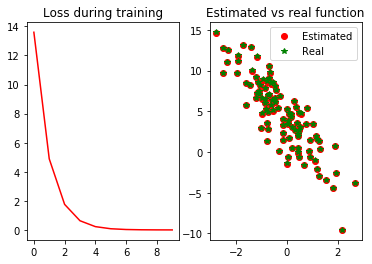

In [33]:
############################################
#    Re-initialize parameters because they
#    were already trained in the first loop
############################################
w[:] = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b[:] = nd.random_normal(shape=num_outputs, ctx=model_ctx)

############################################
#    Script to plot the losses over time
############################################
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()

    plt.show()

learning_rate = .0001
losses = []
plot(losses, X)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)

    plot(losses, X)